In [ ]:
# !pip install pytesseract lanms Shapely

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import pytesseract
import cv2

import PIL
from PIL import Image, ImageFile

In [2]:
plt.rcParams["figure.figsize"] = 16, 9  # Make figures larger

In [3]:
images = glob.glob("/home/gx/mishow_objdet/data/CaptureVerification/**/*.jpg", recursive=True)
# images = glob.glob("./test_images-car_num_plates/*")
# images = glob.glob("/mnt/9C5E1A4D5E1A2116/datasets/ICDAR_2015/test_img/**/*.jpg", recursive=True)
len(images)

173

In [4]:
pytesseract.image_to_string(Image.open(np.random.choice(images)))

'3. A method (10000) for directing webview client/user to view required screen capture within its presentation session where the\nuser is not able to only view the required screen capture, but also navigate to other screen captures within the same\npresentation session.\n\n4. A method (1000) for composite search and retrieval of presentation screen captures characterized by the steps of:\na) live streaming of presenter device desktop screen and recording of presenter speech (1100).\nb) screen capturing of presentation video (1200); and\nc) processing of stored screen captures and recorded speech signal (1300).\n\n5. The method according to claim 4, wherein the step of screen capturing of presentation video (1200) consists of:\n\na) getting the content type of a video frame (20001);\nb) determining if the video frame contains valuable presentation content (20002); and\nc) saving the video frame for further processing if it contains valuable presentation content (20003).\n\n6. The pened 

## Inference

In [5]:
from detect import Predictor

In [6]:
predictor = Predictor(config_path="./runs/deeplabv3plus_resnet50_scope512_merged32_icdar2015/code/configs/config.yaml",
                      device="cpu")
# predictor = Predictor(config_path="./runs/rn50_scope512_inter128_64_32_merged32_icdar2015/code/configs/config.yaml",
#                       device="cpu")

using device: cpu
scope: 512
scale: 4


In [7]:
# The input preprocessing that was used to train the model
predictor.preprocessing_params

{'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}

In [8]:
# The input image size (side length) / model output size (side length) ratio
predictor.scale

4

In [9]:
# The input image size that was used to train the model
predictor.scope

512

>>> original img size: (1080, 1920, 3)
>>> resized img size: (512, 512, 3)
>>> ratio_h: 0.4740740740740741
>>> ratio_w: 0.26666666666666666
>>> restore_polys: valid_pos shape: (946, 2)
>>> restore_polys: valid_geo shape: (5, 946)
>>> restore_polys: score_shape: (128, 128)
>>> restore_polys: scale: 4
>>> restore_polys: d    : [[ 8.778704   7.330261   6.9640274 ...  9.049967   9.031989   9.563646 ]
 [15.808996  16.925234  16.975664  ...  2.1953518  2.8823528  2.9763858]
 [ 9.629905  15.426993  18.371685  ... 22.410917   8.95813   22.18542  ]
 [53.17628   63.467556  57.076817  ... 22.30114   24.058483   7.4540324]]
>>> restore_polys: angle: [-2.89705545e-02 -8.31958000e-03 -1.41432583e-02 -1.41856717e-02
 -1.49515383e-02 -4.68527013e-03  8.19159206e-03  9.79392044e-03
  4.40588826e-03  9.93361231e-03  1.52834449e-02  2.10826863e-02
  2.22472157e-02  3.48888896e-02 -5.49832499e-03  2.51934621e-02
  4.38472852e-02  1.27296811e-02  2.28488613e-02  2.03325488e-02
  5.96814416e-03 -1.40074990e

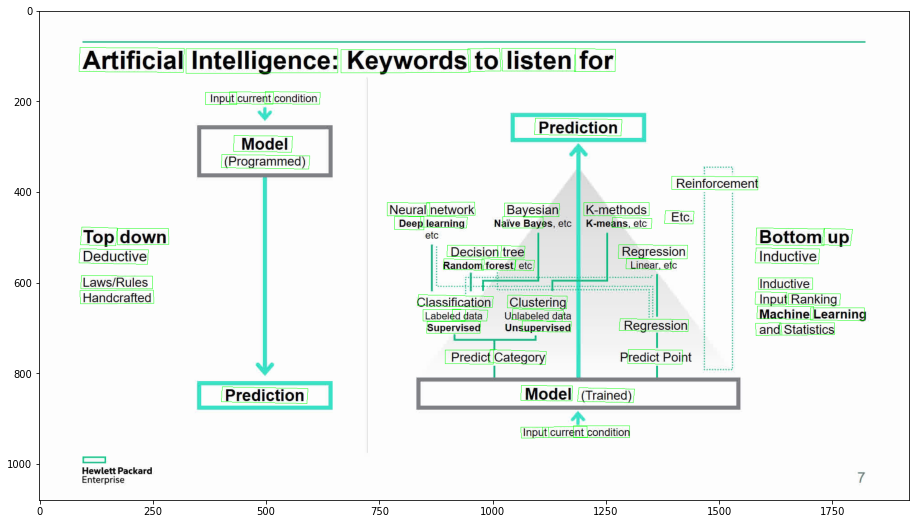

In [17]:
# Make prediction and plot image

boxes, img = predictor.predict(np.random.choice(images), 
                  save_img=False,  # Don't save image on disk
                  return_img=True,  # Return image
                  score_thresh=0.9, 
                  nms_thresh=0.2)
plt.imshow(img)

## Crop patches from image

In [ ]:
def euclidean_dist(pt1: np.ndarray, pt2: np.ndarray) -> float:
    """Compute the euclidean distance between a pair of points."""
    x_diff = pt2[0] - pt1[0]
    y_diff = pt2[1] - pt1[1]
    return (x_diff ** 2 + y_diff ** 2) ** 0.5


def crop_rotated_text(img, boxes: np.ndarray):
    """Ref: https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/"""
    
    # Read image using opencv
    if isinstance(img, str):
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif isinstance(img, PIL.JpegImagePlugin.JpegImageFile):
        img = np.array(img)
    
    cropped_boxes = []
    for box in boxes:
        # Take first eight values in box, model returns 9, final value is the rotation
        # NOTE: Box from model is in the following format: top left, top right, bottom right, bottom left
        box = box[:8]
        
        if isinstance(box, list):
            box = np.array(box)
        
        # Reshape box as pairs of points
        cnt = np.array(box).reshape(-1, 2)
#         print("shape of cnt: {}".format(cnt.shape))

        # Compute width and height from box
        width = int(max(euclidean_dist(cnt[0], cnt[1]), euclidean_dist(cnt[2], cnt[3])))
        height = int(max(euclidean_dist(cnt[0], cnt[3]), euclidean_dist(cnt[1], cnt[2])))
#         print(f"width: {width}")
#         print(f"height: {height}")
    
        # This is our source points
        src_pts = cnt.astype("float32")
#         print(f"src_pts: {src_pts}")
        
        # This is our destination points that we want to warp onto
        dst_pts = np.array([
            [0, 0],
            [width-1, 0],
            [width-1, height-1],
            [0, height-1],
        ], dtype="float32")
#         print(f"dst_pts: {dst_pts}")

        # Get the perspective transformation matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Directly warp the rotated rectangle to get the straightened rectangle
        warped = cv2.warpPerspective(img, M, (width, height))
        cropped_boxes.append(warped)
        
#         print()
    
    return cropped_boxes

In [ ]:
cropped = crop_rotated_text(img, boxes=boxes)
print(len(f"num crops: {len(cropped)}"))

In [ ]:
plt.imshow(cropped[0])

In [ ]:
plt.imshow(cropped[1])

In [ ]:
plt.imshow(cropped[2])

In [ ]:
plt.imshow(cropped[3])

## Apply OCR on cropped regions

In [ ]:
pytesseract.image_to_string(cropped[0])

In [ ]:
pytesseract.image_to_string(cropped[1])

In [ ]:
pytesseract.image_to_string(cropped[2])

In [ ]:
pytesseract.image_to_string(cropped[3])